In [1]:
%%time
# Imports
from utils import *

CPU times: total: 4.89 s
Wall time: 19 s


File-Reading

In [2]:
%%time

# Get start time
start = time.perf_counter()

# File-Reading
path = os.path.join(os.getcwd() , out_file) # from utils
user = []
ts = []
# ca = []
tweets = []
mentions = []
# coord = []
country = []

with open(path , 'r' , encoding='utf-8') as in_file:
    csv_reader = csv.reader(in_file , delimiter = "|")
    for line in csv_reader:
        user.append(line[0])
        ts.append(line[1])
        # ca.append(line[2])
        tweets.append(line[3])
        mentions.append(line[4])
        # coord.append(line[5])
        country.append(line[6])

CPU times: total: 39.4 s
Wall time: 42.4 s


In [36]:
%%time
# Convert timestamp to datetime format
ts_convert = [datetime.datetime.fromtimestamp(int(dt)//1000) for dt in ts]

twt_df = pd.DataFrame(
    list(zip(user , ts_convert , tweets)) , columns = ['user' , 'ts' , 'tweet_id']
)

twt_df = twt_df[twt_df['tweet_id']!="None"].drop_duplicates()
print(f'length of tweet df is {len(twt_df)}')
twt_df.head()

length of tweet df is 15033548
CPU times: total: 1min 9s
Wall time: 1min 12s


,user,ts,tweet_id
0,127625257,2022-06-01 00:00:00,1531772510450208769
1,1092190045,2022-06-01 00:00:00,1531772510701748225
2,28993079,2022-06-01 00:00:00,1531772513306525696
3,867134762,2022-06-01 00:00:00,1531772513809842176
4,635624391,2022-06-01 00:00:01,1531772514262831104


# **02 - USERS**
### **Question - 1**

In [37]:
%%time
twt_df_usr = twt_df.groupby('user').agg(num_twt = ('tweet_id' , 'nunique')).reset_index()
twt_df.head()

CPU times: total: 33.5 s
Wall time: 34.1 s


,user,ts,tweet_id
0,127625257,2022-06-01 00:00:00,1531772510450208769
1,1092190045,2022-06-01 00:00:00,1531772510701748225
2,28993079,2022-06-01 00:00:00,1531772513306525696
3,867134762,2022-06-01 00:00:00,1531772513809842176
4,635624391,2022-06-01 00:00:01,1531772514262831104


CPU times: total: 359 ms
Wall time: 391 ms


Text(0.5, 1.0, 'Histogram for Number of Tweets made by  Users')

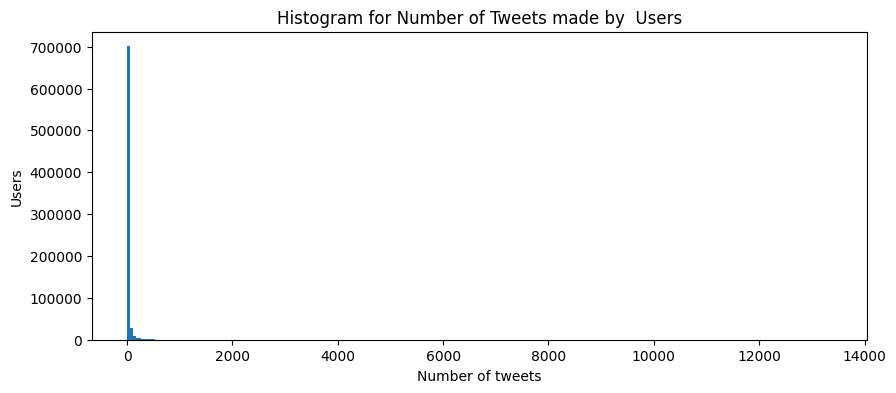

In [38]:
%%time
fig , ax = plt.subplots(figsize = (10 , 4));
freq , bins , patches = ax.hist(twt_df_usr.num_twt , bins = 250);
ax.set_ylabel('Users');
ax.set_xlabel('Number of tweets');
plt.title('Histogram for Number of Tweets made by  Users');

In [39]:
print(f'{90}th quantile -> {np.quantile(twt_df_usr.num_twt , q = 0.9)}')
print(f'{95}th quantile -> {np.quantile(twt_df_usr.num_twt , q = 0.95)}')
print(f'{99}th quantile -> {np.quantile(twt_df_usr.num_twt , q = 0.99)}')
print(f'{100}th quantile -> {np.quantile(twt_df_usr.num_twt , q = 1.00)}')

90th quantile -> 37.0
95th quantile -> 76.0
99th quantile -> 289.0
100th quantile -> 13376.0


That's not very enlightening. Let's see if we can do better manually!

CPU times: total: 1.02 s
Wall time: 1.11 s


Text(0, 0.5, 'log10(number of users)')

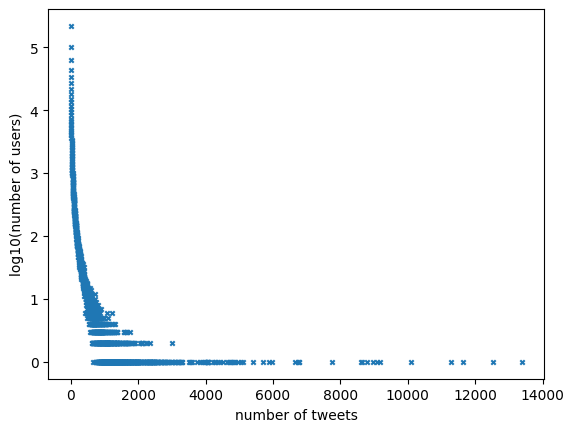

In [40]:
%%time
twt_df_usr_2 = twt_df_usr.groupby('num_twt').agg(users = ('user' , 'nunique')).reset_index()

# Applying log-log transformations on both
twt_df_usr_2['log_users'] = np.log10(twt_df_usr_2['users'])
twt_df_usr_2['log_twt'] = np.log10(twt_df_usr_2['num_twt'])

# Plot
fig , ax = plt.subplots()
ax.scatter(twt_df_usr_2['num_twt'] , twt_df_usr_2['log_users'] , s = 10 , marker = 'x');
ax.set_xlabel('number of tweets');
ax.set_ylabel('log10(number of users)');

We see that this plot roughly agrees with the histogram. It helps us understand that the majority of users tweet between $1$ and $2000$ times (we will return to quantifying this a little later). <br/>
However, there are *some* users who have tweeted over $10,000$ times, with the top user (by volume of tweets) having tweeted $13,376$ times! <br/>
Seeing that there are 30 days in our dataset, this user must have tweeted $\frac{13376}{30 \cdot 24} = 18.6$ times per hour, every hour of every day of the month. This is a bit ludicrous. <br/>

CPU times: total: 31.2 ms
Wall time: 32 ms


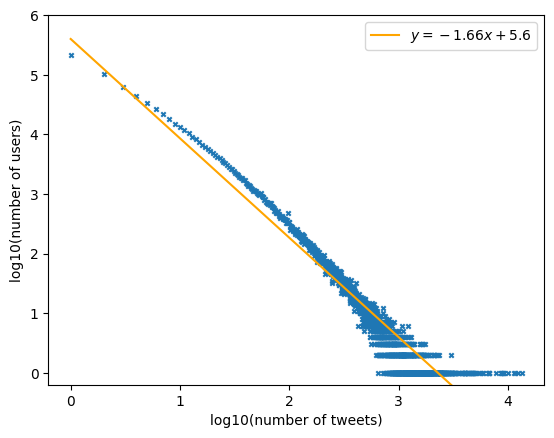

In [41]:
%%time
fig , ax = plt.subplots()
ax.scatter(twt_df_usr_2['log_twt'] , twt_df_usr_2['log_users'] , s = 10 , marker = 'x');
ax.set_xlabel('log10(number of tweets)');
ax.set_ylabel('log10(number of users)');

# Eyeballing the equation of the line
x = np.linspace(0 , 4)
y = (-5/3)*x + 5.6
ax.plot(x , y , color = 'orange' , label = '$y=-1.66x+5.6$')
plt.ylim(-0.2 , 6);
plt.legend(loc = 'upper right');

CPU times: total: 297 ms
Wall time: 346 ms


<AxesSubplot: xlabel='log_twt', ylabel='log_users'>

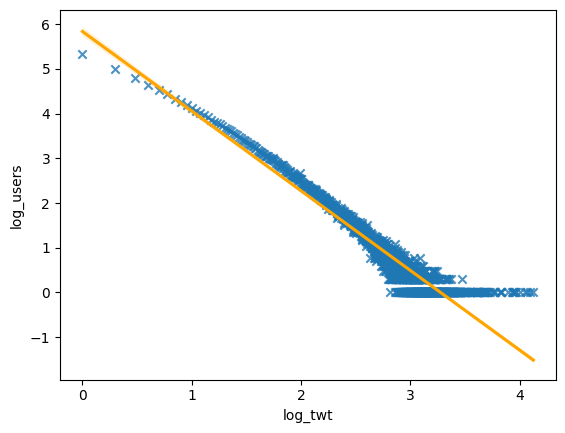

In [42]:
%%time
# Drawback with this is that it doesn't allow us to access the lin reg line!
sns.regplot(
    x = twt_df_usr_2['log_twt'] , y = twt_df_usr_2['log_users'] , 
    scatter = True , 
    fit_reg = True , 
    marker = 'x' , 
    line_kws = {'color' : 'orange'}
)

$$
Y = 5.6 -1.666X
\\
Knowing \ that\ Y = log_{10}y \ and\ X = log_{10}x,
\\
y = 10^{5.6}x^{-1.666}
$$

From this preliminary standpoint, these accounts appear to be bots, but more investigation is needed.

### **Question - 2**

In [43]:
%%time
twt_df_usr.sort_values('num_twt' , ascending=False).head(5)

CPU times: total: 156 ms
Wall time: 160 ms


,user,num_twt
199506,1402775770481713157,13376
267100,1491316688549253120,12518
736010,954732087235563520,11628
188394,1384110594,11294
27730,1069583615762288642,10087


In [44]:
# twt_df[twt_df['user'] == '1402775770481713157'].head(4) # crazy halal turkish account! political bot?
# twt_df[twt_df['user'] == '1491316688549253120'].head(4) # Daily News 79
# twt_df[twt_df['user'] == '954732087235563520'].head(4) # Christian Antolic
# twt_df[twt_df['user'] == '1384110594'].head(4) #L'Hora Catalana - tweets random times e.g.: "It's five minutes to half past eleven in the morning" // probably bot??
twt_df[twt_df['user'] == '1069583615762288642'].head(4) # minijob-anzeigen.de - German Job website - "Automated"

,user,ts,tweet_id
771,1069583615762288642,2022-06-01 00:03:01,1531773273255866368
774,1069583615762288642,2022-06-01 00:03:02,1531773275021484032
776,1069583615762288642,2022-06-01 00:03:02,1531773276086738949
779,1069583615762288642,2022-06-01 00:03:02,1531773277156388867


More investigation is needed to peer into their behaviour. Names, post content and patterns of timestamps may be a good place to start!

In [45]:
%%time

#Create a day dataframe
day_df = pd.DataFrame(
    [
        [0 , 'Mon'],
        [1 , 'Tue'],
        [2 , 'Wed'],
        [3 , 'Thu'],
        [4 , 'Fri'],
        [5 , 'Sat'],
        [6 , 'Sun'],
    ] ,
    columns = ['day' , 'dayofweek']
)

twt_df['hour'] = twt_df['ts'].dt.hour
twt_df['day'] = twt_df['ts'].dt.day_of_week
twt_df = twt_df.merge(day_df , on = 'day' , how = 'inner')

CPU times: total: 5.17 s
Wall time: 5.36 s


In [106]:
# def vis_hi_usage(df , users) -> [None]:
#     '''
#     simple visualization of anomalously voluminous tweeters
#     params: df: dataframe; contains user tweets and timestamps
#     params: users: list; intended user
#     return: no return
#     '''
#     fig , axes = plt.subplots(len(users) , 1)
#     for _ , (ax , usr) in enumerate(zip(axes , users)):
#         user = str(usr)
        
#         df_user = df[df['user'] == user].copy()
        
#         df_user['day_hr'] = df_user['day']*100+df_user['hour']
#         df_user_2 = df_user.groupby('day_hr').agg(num_tweets = ('tweet_id' , 'nunique')).reset_index()
#         df_user_2['day_hr'] = df_user_2['day_hr'].astype('str').str.zfill(4)
        
#         ax.plot(df_user_2.day_hr , df_user_2.num_tweets , label = f'User {user}');
#         ax.legend(loc = 'right' , bbox_to_anchor = [1.75,1]);
#         ax.set_xticks(df_user_2.day_hr);
#         ax.set_xticklabels(labels = df_user_2.day_hr, rotation = 90);

In [65]:
# %%time

# vis_hi_usage(df = twt_df, users = [1402775770481713157,1491316688549253120,954732087235563520,1384110594,1069583615762288642])

In [129]:
%%time

def hi_usage(df , user_id , user_nm):
    '''
    simple visualization of anomalously voluminous tweeters
    params: df: dataframe -> contains user tweets and timestamps
    params: user_id: int -> user id
    params: user_nm: str -> name of user
    return: no return
    '''
    fig , ax = plt.subplots(figsize = (15 , 3))

    user = str(user_id)
        
    df_user = df[df['user'] == user].copy()

    # day hour df - some values may be missing in the user-filtered data!
    l1 = [str(i).zfill(2) for i in range(7)]
    l2 = [str(i).zfill(2) for i in range(1,24)]

    day_hr_df = pd.DataFrame([[i+j] for i in l1 for j in l2] , columns = ['day_hr'])
            
    df_user['day_hr'] = df_user['day'].astype('str').str.zfill(2)+df_user['hour'].astype('str').str.zfill(2)
    df_user_2 = df_user.groupby('day_hr').agg(num_tweets = ('tweet_id' , 'nunique')).reset_index().merge(
        day_hr_df , on = 'day_hr' , how = 'outer'
        ).fillna(0).sort_values('day_hr' , ascending = True)

    ax.plot(df_user_2.day_hr , df_user_2.num_tweets , label = f'User -> {user_nm}');

    every_nth = 6
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

    ax.vlines(
        df_user_2.day_hr[::every_nth] , 
        ymin = df_user_2.num_tweets.min() , 
        ymax = df_user_2.num_tweets.max() ,
        alpha = 0.4 , ls = '--');
    # print(df_user_2.day_hr)
    ax.set_xticks(df_user_2.day_hr);
    ax.set_xticklabels(df_user_2.day_hr , rotation = 90);
    ax.set_xlabel('day hour');
    ax.set_ylabel('number of tweets');
    plt.legend(loc = 'best');

    return df_user_2.day_hr

CPU times: total: 0 ns
Wall time: 0 ns


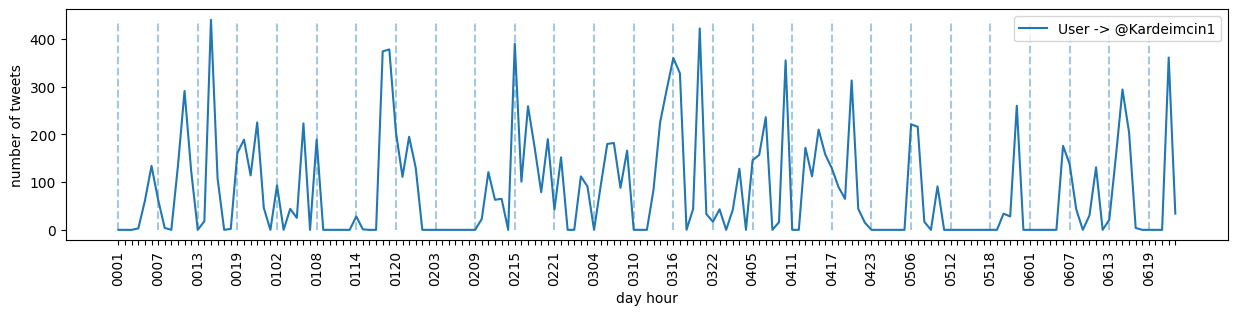

In [130]:
hrs = hi_usage(twt_df , 1402775770481713157 , '@Kardeimcin1')

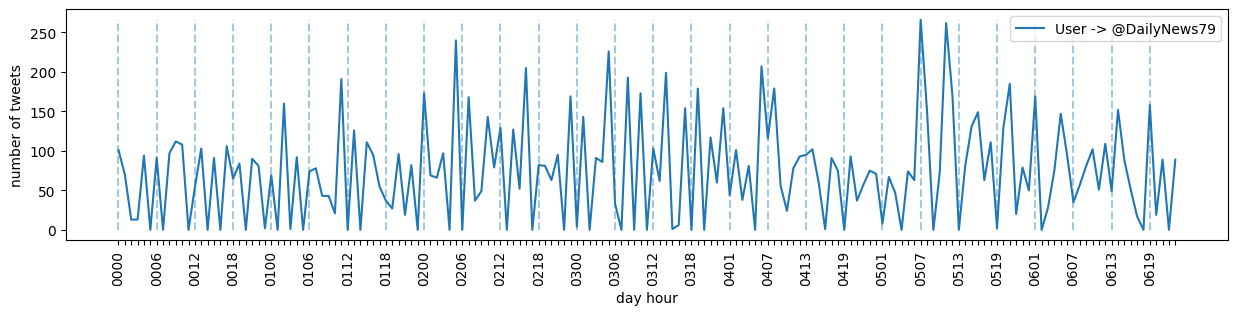

In [131]:
hrs = hi_usage(twt_df , 1491316688549253120 , '@DailyNews79')

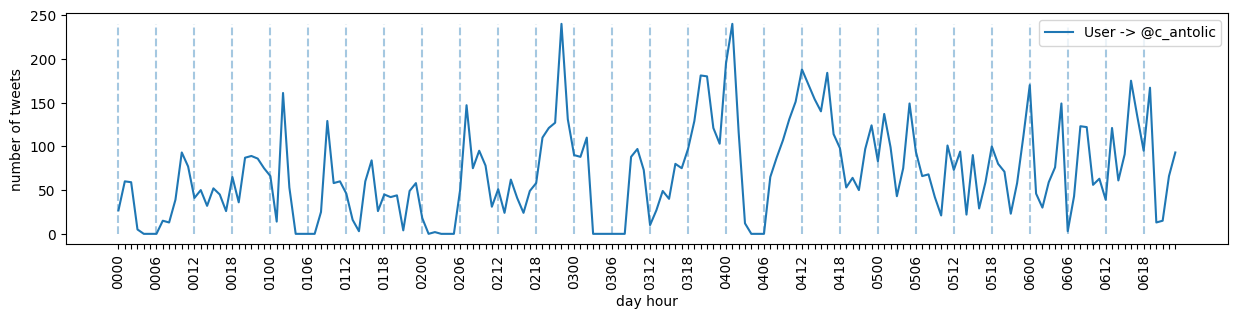

In [132]:
hrs = hi_usage(twt_df , 954732087235563520 , '@c_antolic')

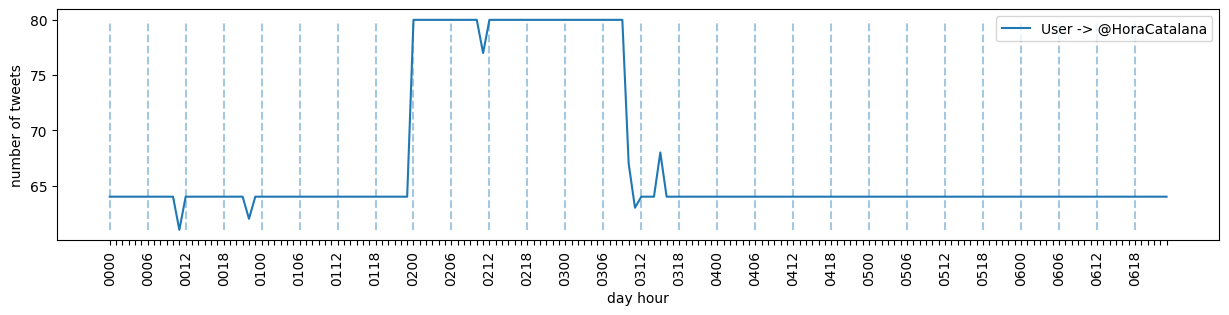

In [133]:
hrs = hi_usage(twt_df , 1384110594 , '@HoraCatalana')

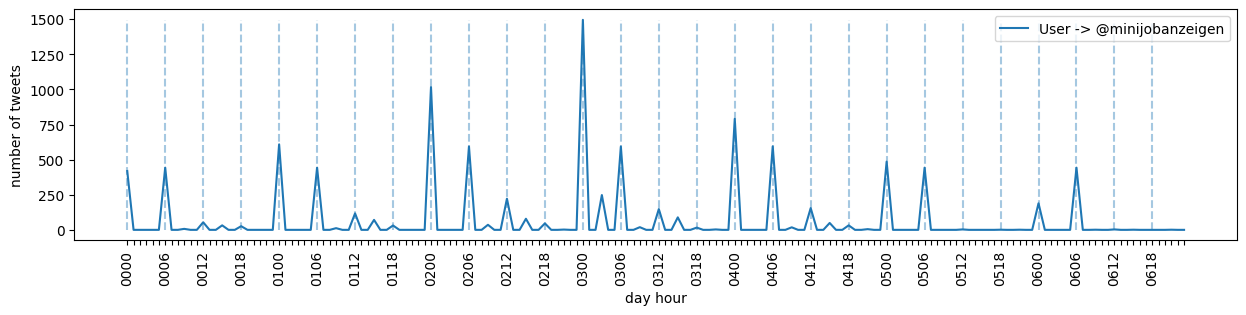

In [134]:
hrs = hi_usage(twt_df , 1069583615762288642 , '@minijobanzeigen')

In [84]:
# Posted back for reference!
# twt_df[twt_df['user'] == '1402775770481713157'].head(4) # crazy halal turkish account! political bot?
# twt_df[twt_df['user'] == '1491316688549253120'].head(4) # Daily News 79
# twt_df[twt_df['user'] == '954732087235563520'].head(4) # Christian Antolic
# twt_df[twt_df['user'] == '1384110594'].head(4) #L'Hora Catalana - tweets random times e.g.: "It's five minutes to half past eleven in the morning" // probably bot??
# twt_df[twt_df['user'] == '1069583615762288642'].head(4) # minijob-anzeigen.de - German Job website - "Automated"

No discernable pattern, apart from maybe 1069583615762288642

### **Question-3**

In [15]:
%%time
# Make DF
twt_mentions_df = pd.DataFrame(
    list(zip(mentions , tweets)) , 
    columns = ['mentions','tweets']
)
# Get rid of null values
twt_mentions_df = twt_mentions_df[twt_mentions_df['tweets']!='None']
# Get rid of duplicates
twt_mentions_df.drop_duplicates(inplace=True)

# Changing from list representation to an actual list
twt_mentions_df['mentions'] = twt_mentions_df['mentions'].apply(lambda x : json.loads(x))
twt_mentions_df = twt_mentions_df.explode('mentions')

CPU times: total: 1min 19s
Wall time: 1min 30s


In [24]:
twt_mentions_df[twt_mentions_df['mentions'] == 118787224].head()

,mentions,tweets
13313,118787224,1531790060017684482
18773,118787224,1531809732519858176
20081,118787224,1531816131744235520
23500,118787224,1531831439964024832
23644,118787224,1531832104908038144


In [18]:
# Grouping to get top 5 users (in terms of number of mentions)
twt_mentions_df_2 = twt_mentions_df[twt_mentions_df['mentions']!="None"].groupby('mentions').agg(num_mentions = ('mentions' , 'count')).reset_index()
twt_mentions_df_2.sort_values('num_mentions', ascending=False).head(5)

,mentions,num_mentions
11617,10228272,22481
200976,68034431,21462
1186956,3131144855,17801
148521,44196397,12487
286159,118787224,10937


*These highly mentioned accounts are probably:*
1. Celebrities/ Influencers
2. Political Figures
3. Companies/ Groups
_____________
**For example**<br/>
10228272 - YouTube<br/>
68034431 - Recep Tayyip Erdogan (President of Turkey)<br/>
3131144855 - BoJo<br/>
44196397 - Elon Musk<br/>
118787224 - Personal account of Working President of TRS
_____________

In [25]:
# %%time

# # Take log-log transform
# twt_mentions_df_3 = twt_mentions_df_2.groupby('num_mentions').agg(users = ('mentions','nunique')).reset_index()
# twt_mentions_df_3['log_users'] = np.log10(twt_mentions_df_3['users'])
# twt_mentions_df_3['log_mentions'] = np.log10(twt_mentions_df_3['num_mentions'])

# # Plot (probably useless since we're not going to do anything with this)
# plt.plot(twt_mentions_df_3['log_users'] , twt_mentions_df_3['log_mentions']);
# plt.xlabel('log users');
# plt.ylabel('log mentions');

### **QUESTION - 4**
Choose 4 countries and compute how often they mention each other. This means you should compute 16 numbers e.g. UK mentions UK, UK mentions
France, France mentions UK etc. Comment on any patterns you observe. [5 marks]

In [3]:
%%time

# Make DF
twt_mentions_df = pd.DataFrame(
    list(zip(user , mentions , tweets , country)) , 
    columns = ['user' , 'mentions' , 'tweet_id' , 'country']
)

twt_mentions_df = twt_mentions_df[twt_mentions_df['tweet_id']!= "None"].drop_duplicates()
# twt_mentions_df = twt_mentions_df[twt_mentions_df['mentions']!= "None"] # Don't remove these now. We may need them for country identification later
print(f'the length of the df is {len(twt_mentions_df)}') # Turn this into an assertion check later!
twt_mentions_df.drop('tweet_id' , axis = 1 , inplace=True)

the length of the df is 15033548
CPU times: total: 48.7 s
Wall time: 52.7 s


In [4]:
# Changing from list representation to an actual list
twt_mentions_df['mentions'] = twt_mentions_df['mentions'].apply(lambda x : json.loads(x))
twt_mentions_df = twt_mentions_df.explode('mentions')
# drop tweets with no mentions
twt_mentions_df.dropna(inplace = True)
print(f'the length of the df is {len(twt_mentions_df)}') # Turn this into an assertion check later!

the length of the df is 16446394


In [5]:
%%time
# Trying to get one primary country per user - the country column is only attached to the user
# Check if primary country adds any value ?
twt_country = twt_mentions_df[['user' ,'country']].drop_duplicates()
twt_country = twt_country[twt_country['country']!= "None"]

twt_mentions_df.drop('country' , axis = 1 , inplace=True)

prim_country = twt_country.groupby(['user','country']).agg(num_occr = ('user','count')).reset_index()

# prim_country['max_occr_country'] = prim_country.groupby('user')['num_occr'].rank(method = "first" , ascending = False)
prim_country['max_occr_country'] = prim_country.groupby('user')['num_occr'].rank(method = "max")
prim_country = prim_country[prim_country['num_occr'] == prim_country['max_occr_country']]

# Use dask to parallelize pandas stuff!
dask_mentions_df = from_pandas(twt_mentions_df, npartitions=8)
# Make data types consistent before joining
dask_mentions_df['user'] = dask_mentions_df['user'].astype('str')
dask_mentions_df['mentions'] = dask_mentions_df['mentions'].astype('str')

dask_user_country_df = from_pandas(prim_country , npartitions=8)

CPU times: total: 19.9 s
Wall time: 21.9 s


In [6]:
twt_country.user.nunique()

482521

In [7]:
prim_country.sort_values('num_occr' , ascending=False).head(3)

,user,country,num_occr,max_occr_country
0,1000001577812463616,Portugal,1,1.0
343672,3301729629,United Kingdom,1,1.0
343683,3301852007,Türkiye,1,1.0


In [159]:
len(dask_mentions_df) , len(dask_user_country_df)

(16446394, 482521)

In [160]:
del twt_mentions_df , 
# del twt_mentions_df_3 , 
# del twt_mentions_df_2 , 
# del twt_df , 
# del day_df , 
# del twt_df_usr , 
# del twt_df_usr_2 , 
del ts_convert , 
del twt_country , 
del prim_country , 
del user , 
del mentions , 
del tweets , 
del country , 
# del ts , 
# del ca ,
# del coord

In [161]:
mentions = dask_mentions_df.merge(
    dask_user_country_df[['user' , 'country']] , on = 'user' , how = 'inner'
    ).merge(
        dask_user_country_df[['user' , 'country']] , left_on = 'mentions' , right_on = 'user' , how = 'inner'
    )
# Quantify the drop - probably because some mentioned accounts have never themselves tweeted anything; hence their country isn't captured 

# See who's mentioning whom?
x_mentions_df = mentions.compute()
x_mentions_df.rename(columns = {'country_x':'user_country' , 'country_y':'mentioned_country'}, inplace = True)
print(f'length = {len(x_mentions_df)}')
x_mentions_df = x_mentions_df[['user_x','user_y','user_country' , 'mentioned_country']]
print(f'length = {len(x_mentions_df)}')

length = 1384246
length = 1384246


In [162]:
# https://www.kaggle.com/datasets/prasertk/country-name-in-different-languages
country_codes = pd.read_csv(
    os.path.join(
        os.getcwd() , 'country name in different languages.csv'
        )
    )

# Let's randomly decide on 4 countries for now.
country_list = ['France' , 'Germany' , 'Spain' , 'Portugal']

# Let's get these countries and the different names they're called by!
restricted_country_names = country_codes[country_codes['en'].isin(country_list)].drop('country_code' , axis = 1)
pivoted_country_names = pd.melt(
    restricted_country_names, id_vars=['en'], var_name='language', value_name='name'
    )[['en' , 'name']].drop_duplicates()

# English names are being left out - add them back in
english_names = [
    ['Germany' , 'Germany'],
    ['France' , 'France'],
    ['Spain' , 'Spain'],
    ['Portugal' , 'Portugal'],
]

english_name_df = pd.DataFrame(english_names , columns = ['en' , 'name'])
pivoted_country_names = pd.concat([pivoted_country_names , english_name_df] , axis = 0).drop_duplicates()

In [163]:
# Names repeated? - Check
t1 = pivoted_country_names.groupby('name').agg('count').sort_values('en' , ascending = False)
print(f'length of duplicates is {len(t1[t1["en"]>1])}') # turn into assertion

length of duplicates is 0


In [164]:
# Changing Non-English names to English names (for consistency)
x_mentions_df_2 = x_mentions_df.merge(
    pivoted_country_names[['en' , 'name']] , 
    left_on = 'user_country' , 
    right_on = 'name',
    how = 'inner'
).merge(
    pivoted_country_names[['en' , 'name']] , 
    left_on = 'mentioned_country' , 
    right_on = 'name',
    how = 'inner'
)

x_mentions_df_2 = x_mentions_df_2[['en_x' , 'en_y']].rename(
    columns = {'en_x':'user_country' , 'en_y':'mentioned_country'}
)[['user_country' , 'mentioned_country']]

# Restricted to 4 countries
print(f'length before grouping : {len(x_mentions_df_2)}')
print(f'sum of occurence : {len(x_mentions_df_2)}')
print("_"*30)

x_mentions_df_3 = x_mentions_df_2.groupby(['user_country' , 'mentioned_country']).agg(occr = ('user_country' , 'count'))

# # Regrouped
print(f'length before grouping : {len(x_mentions_df_3)}')
print(f'sum of occurence : {x_mentions_df_3.sum().occr}')

length before grouping : 339958
sum of occurence : 339958
______________________________
length before grouping : 16
sum of occurence : 339958


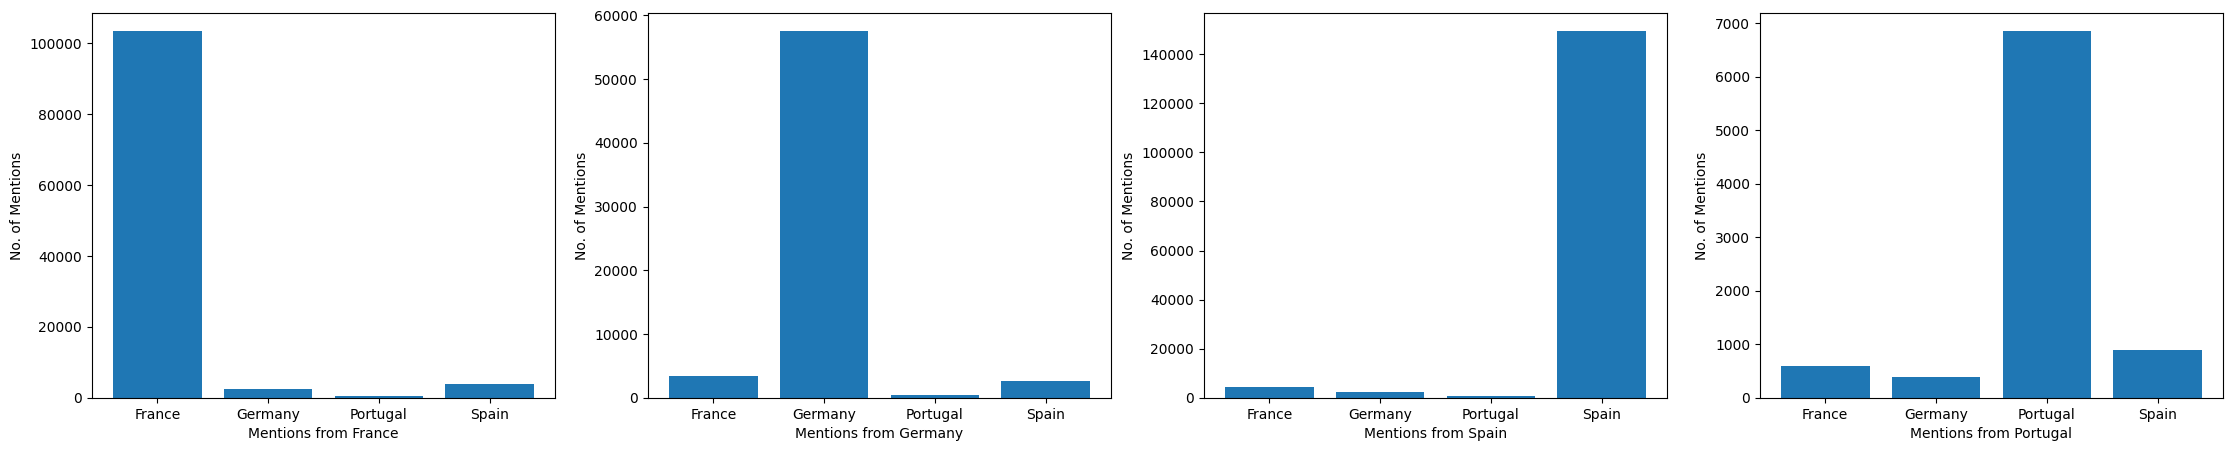

In [165]:
# Graph the number of cross mentions
fig , axes = plt.subplots(1 , len(country_list) , figsize = (27.5 , 5))

for _ , (ax , user) in enumerate(zip(axes , country_list)):
    df = x_mentions_df_3.loc[user]
    ax.bar(df.index , df.occr);
    ax.set_xlabel(f'Mentions from {user}')
    ax.set_ylabel('No. of Mentions');

# Countries seem to mostly be mentioning themselves

In [168]:
x_mentions_df_3.reset_index().pivot_table(index = 'user_country' , columns = 'mentioned_country' , values = 'occr')

mentioned_country,France,Germany,Portugal,Spain
user_country,,,,
France,103423,2537,550,3784
Germany,3424,57534,493,2642
Portugal,596,384,6849,893
Spain,4311,2194,867,149477
